In [1]:
"""
Sample code for semantic image segmentation using UNet

Step-by-step Outline:
1. Load, split, and process the dataset
2. Build UNet model and specify the loss function
3. Train the model
4. Test the model
"""

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import imageio.v2 as imageio

In [3]:
# LOAD AND PROCESS THE DATASET
# Load images and masks
image_path = os.path.join(os.getcwd(), "images", "CameraRGB")
mask_path = os.path.join(os.getcwd(), "images", "CameraMask")

# List of files in the directory
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)

# Filter files to include only those with expected extensions
# valid_extensions = (".png", ".jpg", ".jpeg")
valid_extensions = (".png")

image_paths_list = [os.path.join(image_path, img) for img in image_list_orig if img.endswith(valid_extensions)]
mask_paths_list = [os.path.join(mask_path, msk) for msk in mask_list_orig if msk.endswith(valid_extensions)]
print(f"Total images: {len(image_paths_list)} \nTotal masks: {len(mask_paths_list)}")

Total images: 1060 
Total masks: 1060


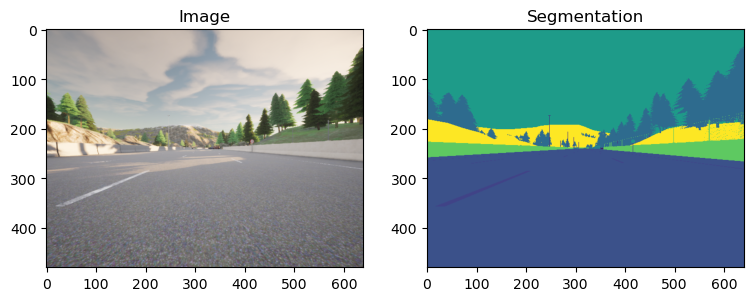

In [17]:
# Check some images and corresponding masks
N = 10
img = plt.imread(image_paths_list[N])
mask = plt.imread(mask_paths_list[N])

fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask[:, :, 0])
ax[1].set_title('Segmentation')
plt.show()

In [ ]:
# Create a TensorFlow dataset object from a list of file paths
dataset = tf.data.Dataset.from_tensor_slices((image_paths_list, mask_paths_list))  # No shuffling: order is maintained

In [24]:
# Function to help process the images and masks
def process_path(img_path, msk_path):
    """
    Reads and processes the image and mask files.

    Arguments:
        img_path -- Path to the image file.
        msk_path -- Path to the mask file.

    Returns:
        img -- Processed image tensor.
        msk -- Processed mask tensor.
    """
    # Read and decode the image file
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Read and decode the mask file
    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_png(msk, channels=3)
    # Reduce the mask along the channel axis
    msk = tf.math.reduce_max(msk, axis=-1, keepdims=True)
    print(mask.shape)

    return img, msk

In [25]:
def preprocess(img, msk, new_size=(96, 128)):
    """
    Resizes the image and mask to the target size.

    Arguments:
        img -- Input image tensor.
        msk -- Input mask tensor.
        new_size -- New size of the target image (default = (96, 128))

    Returns:
        input_image -- Resized image tensor.
        input_mask -- Resized mask tensor.
    """
    # Resize the image and mask to new_size using 'nearest.' It just picks the closest pixel, avoiding complex calculations.
    # It's fast, preserves edges/sharp details, although it can cause pixelation artifacts
    resized_image = tf.image.resize(img, size=new_size, method='nearest')
    resized_mask = tf.image.resize(msk, size=new_size, method='nearest')

    return resized_image, resized_mask

In [ ]:
image_ds = dataset.map(process_path)
resized_image_ds = image_ds.map(preprocess)

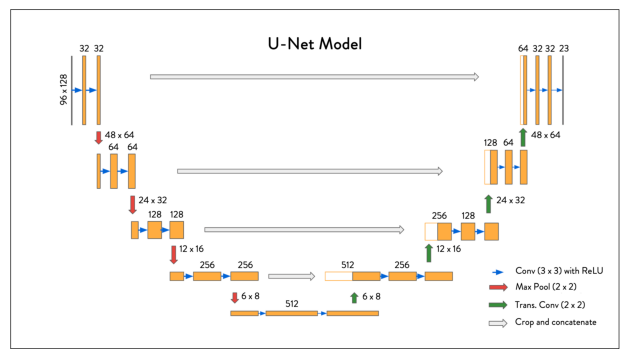

In [27]:
# BUILD THE UNET MODEL
model_path = os.path.join(os.getcwd(), "images", "ModelArchitecture", "unet.png")
encoder_path = os.path.join(os.getcwd(), "images", "ModelArchitecture", "encoder.png")
decoder_path = os.path.join(os.getcwd(), "images", "ModelArchitecture", "decoder.png")

# Show the model architecture
model_image = plt.imread(model_path)
plt.imshow(model_image)
plt.axis('off')
plt.tight_layout()
plt.show()

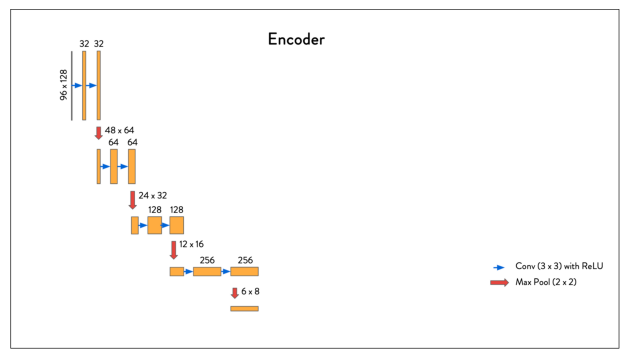

In [28]:
# First let's focus on building the encoder block
plt.imshow(plt.imread(encoder_path))
plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
# Build the encoder block
def encoder_block(inputs=None, n_filters=32, dropout_prob=0., max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers (default = 32)
        dropout_prob -- Dropout probability (default = 0)
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume (default = True)

    Returns:
        next_layer -- Next layer will go into the next block.
        skip_connection -- Skip_connection will go into the corresponding decoding block
    """

    # First convolutional layer
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)

    # Second convolutional layer with same settings
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    # Add a dropout layer if dropout_prob > 0
    if dropout_prob > 0:
        conv = Dropout(rate=dropout_prob)(conv)

    # Add a MaxPooling layer if max_pooling is True
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # Set the skip connection
    skip_connection = conv

    return next_layer, skip_connection

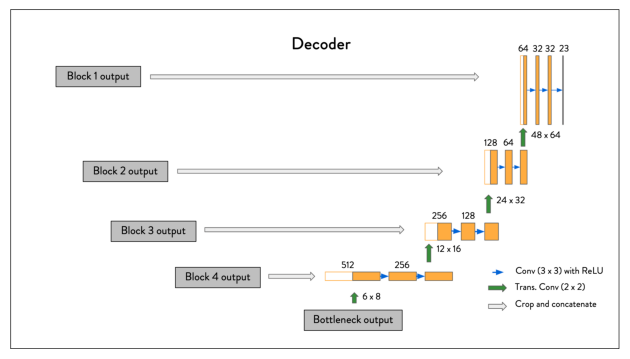

In [30]:
# Build a decoder block
plt.imshow(plt.imread(decoder_path))
plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
def decoder_block(previous_layer_input, skip_connection_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        previous_layer_input -- Input tensor from the previous layer
        skip_connection_input -- Input tensor from the previous skip layer
        n_filters -- Number of filters for the convolutional layers

    Returns:
        conv -- Tensor output
    """

    # Transposed convolution (upsampling) layer
    up = Conv2DTranspose(filters=n_filters,
                         kernel_size=3,
                         strides=(2, 2),
                         padding='same')(previous_layer_input)

    # Merge the previous output and the skip connection
    merge = concatenate([up, skip_connection_input], axis=3)  # Concatenate along the channels axis

    # First convolutional layer after concatenation
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

    # Second convolutional layer
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    return conv

In [32]:
# Build the U-Net Architecture
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    U-Net model for semantic segmentation

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes

    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    # Contracting Path (i.e., encoding)
    eblock1 = encoder_block(inputs, n_filters)
    eblock2 = encoder_block(eblock1[0], n_filters * 2)
    eblock3 = encoder_block(eblock2[0], n_filters * 4)
    eblock4 = encoder_block(eblock3[0], n_filters * 8, dropout_prob=0.3)
    eblock5 = encoder_block(eblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (i.e., decoding)
    dblock6 = decoder_block(eblock5[0], eblock4[1], n_filters * 8)
    dblock7 = decoder_block(dblock6, eblock3[1], n_filters * 4)
    dblock8 = decoder_block(dblock7, eblock2[1], n_filters * 2)
    dblock9 = decoder_block(dblock8, eblock1[1], n_filters)

    # Final convolution
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(dblock9)

    # Output layer
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [33]:
img_height, img_width, num_channels = 96, 128, 3
unet = unet_model((img_height, img_width, num_channels), n_filters=32, n_classes=23)
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 128,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 128,   │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 12, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # For pixel-wise multiclass pred.
             metrics=['accuracy'])

AUTOTUNE = tf.data.experimental.AUTOTUNE
m = len(resized_image_ds)  # 1060
train_dataset = resized_image_ds.shuffle(m).batch(batch_size=32).prefetch(AUTOTUNE)

In [41]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-6)

checkpoint_filepath = os.path.join(os.getcwd(), "unet_checkpoint.weights.h5")
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='loss', verbose=0, save_best_only=True, save_weights_only=True)
callbacks = [early_stopping, reducelr, checkpoint]

num_epochs = 40
unet_history = unet.fit(train_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8626 - loss: 0.4826 - learning_rate: 0.0010
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8743 - loss: 0.4355 - learning_rate: 0.0010
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8897 - loss: 0.3703 - learning_rate: 0.0010
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9005 - loss: 0.3338 - learning_rate: 0.0010
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9122 - loss: 0.2923 - learning_rate: 0.0010
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9154 - loss: 0.2879 - learning_rate: 0.0010
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9246 - loss: 0.2553 - learning_rate: 0.0010
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9198 - loss: 0.2730 - learning_rate: 0.0010
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9248 - loss: 0.2525 - learning_rate: 0.0010
Epoch 10/40
34/34 ━━━━━━━━━━

In [42]:
def history_plots(model_history):
    """
    Plots the training loss and accuracy from the model history.

    Arguments:
        model_history -- A History object returned from model.fit()
    """
    # Extract loss and accuracy
    loss = model_history.history['loss']
    accuracy = model_history.history['accuracy']

    # Extract validation loss and accuracy if they exist
    val_loss = model_history.history.get('val_loss')
    val_accuracy = model_history.history.get('val_accuracy')

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


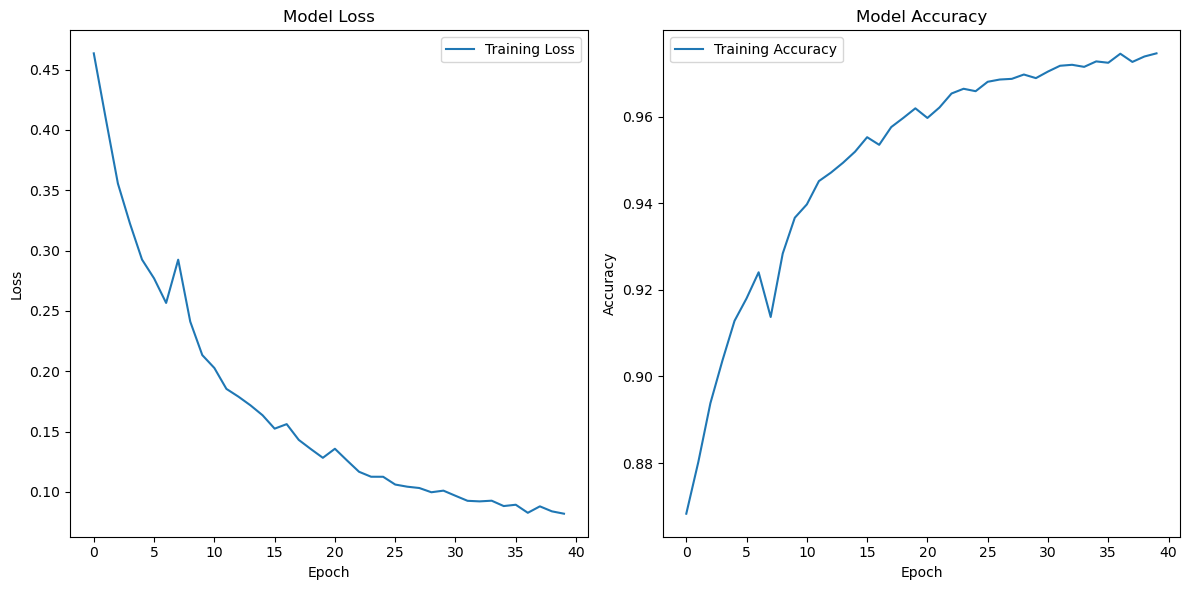

In [43]:
history_plots(unet_history)

In [44]:
fine_epochs = 30
total_epochs = num_epochs + fine_epochs

num_epochs = 40
unet_history_fine = unet.fit(train_dataset,
                        epochs=total_epochs,
                        initial_epoch=unet_history.epoch[-1],
                        callbacks=callbacks)

Epoch 40/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9764 - loss: 0.0757 - learning_rate: 0.0010
Epoch 41/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9776 - loss: 0.0720 - learning_rate: 0.0010
Epoch 42/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9765 - loss: 0.0749 - learning_rate: 0.0010
Epoch 43/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9746 - loss: 0.0815 - learning_rate: 0.0010
Epoch 44/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9764 - loss: 0.0744 - learning_rate: 0.0010
Epoch 45/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9780 - loss: 0.0701 - learning_rate: 0.0010
Epoch 46/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9787 - loss: 0.0678 - learning_rate: 0.0010
Epoch 47/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9777 - loss: 0.0705 - learning_rate: 0.0010
Epoch 48/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9772 - loss: 0.0720 - learning_rate: 0.0010
Epoch 49/70
34/34 ━

In [45]:
loss = unet_history.history['loss']
loss += unet_history_fine.history['loss']

acc = unet_history.history['accuracy']
acc += unet_history_fine.history['accuracy']

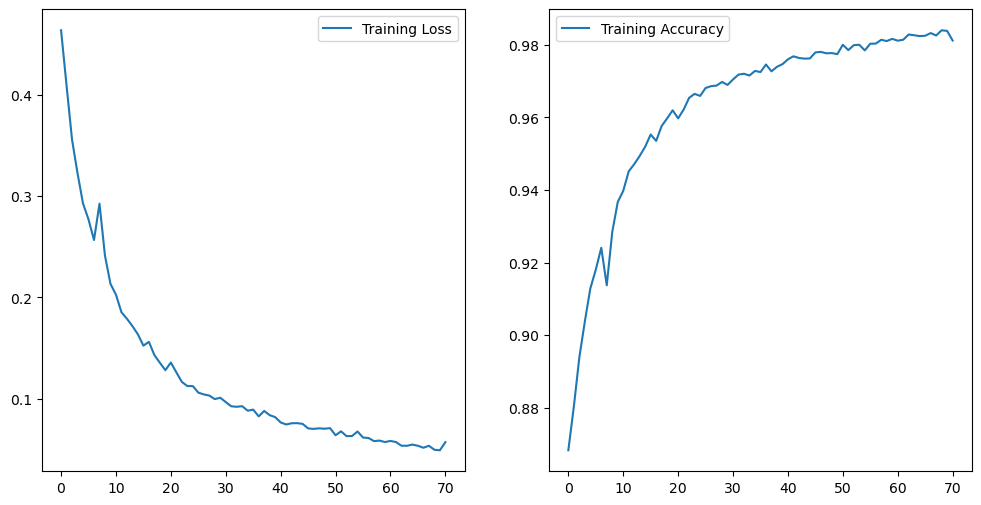

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.legend()
plt.show()

In [51]:
def display(display_list):
    """
    Display a list of images side by side.

    Arguments:
        display_list -- List of image tensors to be displayed
    """
    # Titles for the various subplots
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    # Create subplots
    fig, axes = plt.subplots(1, len(display_list), figsize=(15, 5))

    # Loop through the display list and plot each image
    for i, ax in enumerate(axes):
        ax.set_title(title[i])
        # Convert the tensor to an image and display it
        ax.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        ax.axis('off')  # Turn off the axis for a cleaner look
    plt.tight_layout()
    plt.show()


def create_mask(pred_mask):
    # Use argmax to get the index of the class with the highest probability
    pred_mask = tf.argmax(pred_mask, axis=-1, )

    # Add a new axis to maintain the shape for further processing
    pred_mask = pred_mask[..., tf.newaxis]

    # Return the first image in the batch
    return pred_mask[0]

In [52]:
def show_predictions(data=None, num=1, model=unet, sample_image=None, sample_mask=None):
    """
    Displays predictions for the first image of each of the 'num' batches.

    Arguments:
        data -- tf.data.Dataset containing image and mask pairs.
        num -- Number of batches to display.
        model -- Trained model for making predictions.
        sample_image -- A sample image to use for predictions if no dataset is provided.
        sample_mask -- The corresponding mask for the sample image.
    """
    if data:
        for img, msk in data.take(num):
            pred_mask = model.predict(img)
            display([img[0], msk[0], create_mask(pred_mask)])
    else:
        if sample_image is not None and sample_mask is not None:
            pred_mask = model.predict(sample_image[tf.newaxis, ...])
            display([sample_image, sample_mask, create_mask(pred_mask)])
        else:
            print("No dataset or sample image provided.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


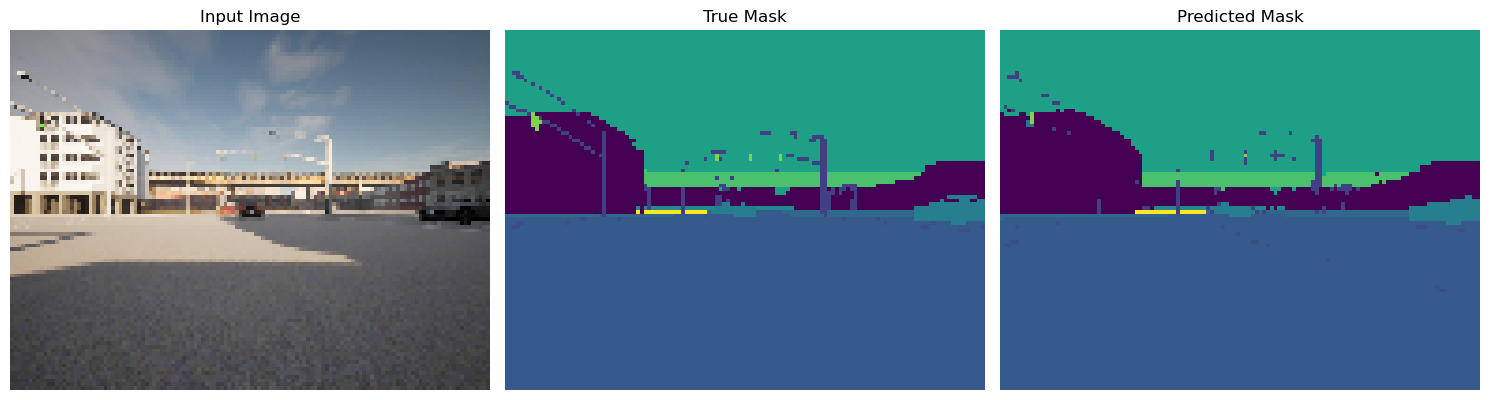

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


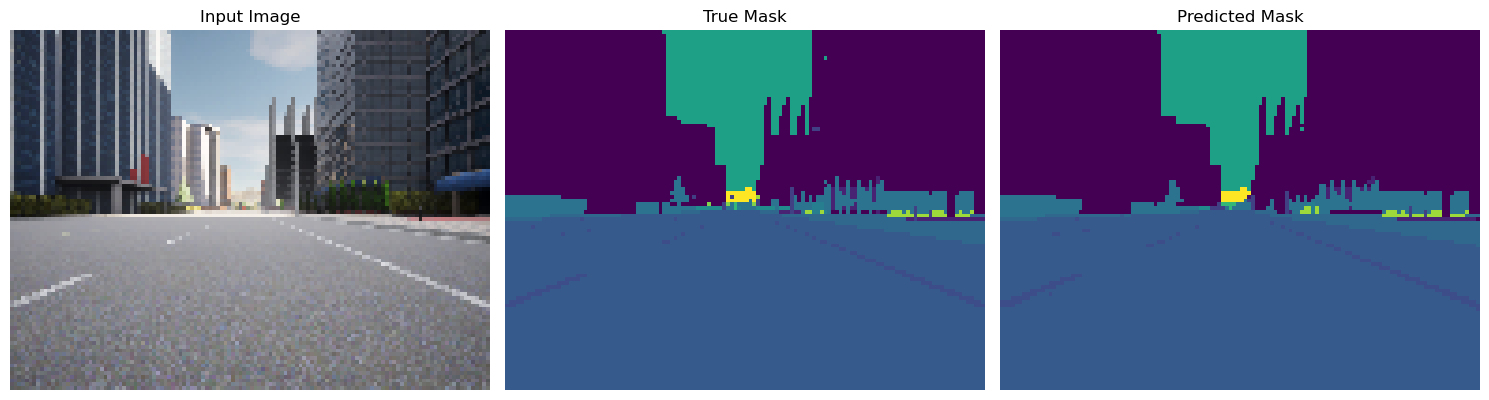

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


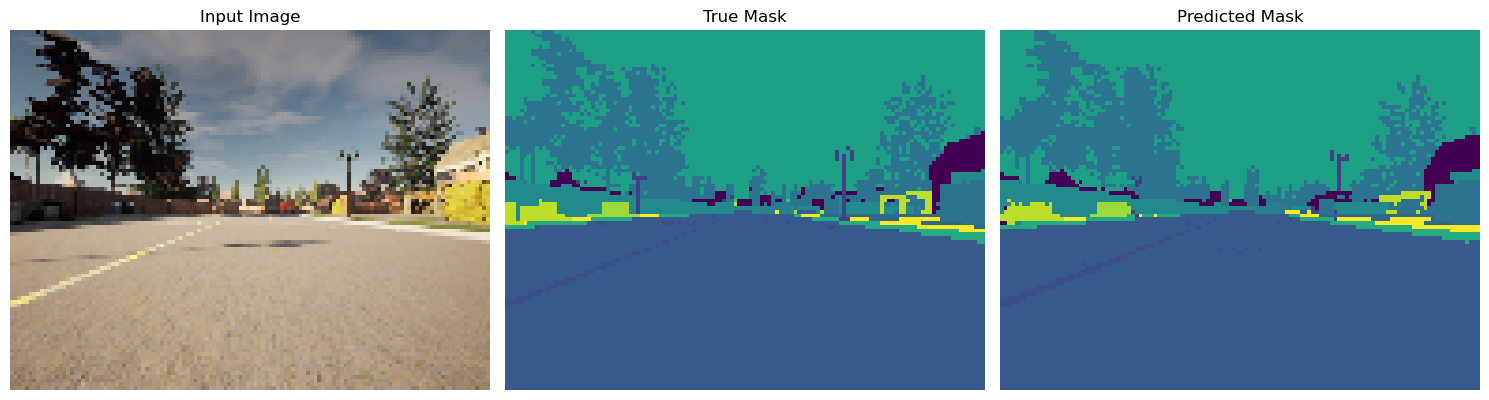

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


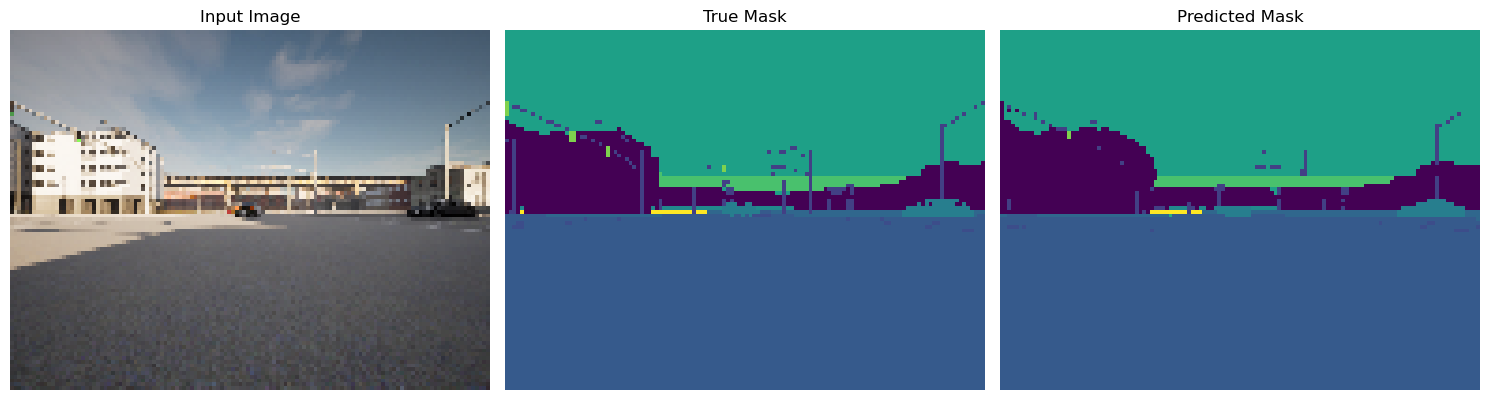

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


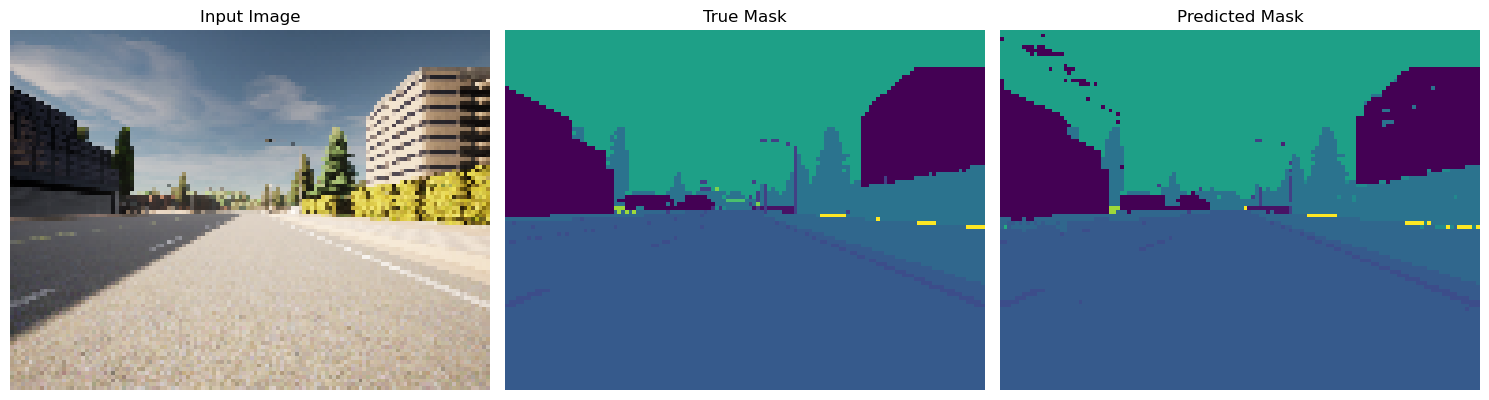

In [53]:
# Show the predictions for the first image of the first 5 batches
show_predictions(train_dataset, 5)

In [55]:
# Save model architecture and weights
model_json = unet.to_json()
model_path = os.path.join(os.getcwd(), "my-unet", "unet.json")
with open(model_path, 'w') as json_file:
    json_file.write(model_json)

weight_path = os.path.join(os.getcwd(), "my-unet", "unet.weights.h5")
unet.save_weights(weight_path)

**Note:** Model can be fine-tuned with additional training.